In [1]:
import os
os.chdir('D:\Birkbeck\MSc Data Science\Project\Data sets\Selected datasets')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,explained_variance_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision',3)

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('la_train_data.csv')
train_data = train_data.drop(columns ='Unnamed: 0')
train_data['all_sls_price'] = train_data['all_sls_price']/1000
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   la_code                 3425 non-null   object 
 1   la_name                 3425 non-null   object 
 2   year                    3425 non-null   int64  
 3   g_belt_area             3425 non-null   int64  
 4   total_area              3425 non-null   int64  
 5   rpi                     3425 non-null   float64
 6   int_rate_max            3425 non-null   float64
 7   int_rate_min            3425 non-null   float64
 8   median_income           3425 non-null   int64  
 9   population              3425 non-null   int64  
 10  num_hh_1dp              3425 non-null   float64
 11  num_hh_>2dp             3425 non-null   float64
 12  num_hh_2dp              3425 non-null   float64
 13  num_hh_1f               3425 non-null   float64
 14  num_hh_1m               3425 non-null   

In [4]:
#import test data
test_data = pd.read_csv('la_test_data.csv')
test_data = test_data.drop(columns ='Unnamed: 0')
test_data['all_sls_price'] = test_data['all_sls_price']/1000
#test_data.info()

In [5]:
#scale the data 
X_train = train_data.iloc[ : , 2:43]
y_train = train_data.iloc[ : , -1]

X_test = test_data.iloc[ : , 2:43]
y_test = test_data.iloc[ : , -1]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

## Spot check possible models

In [6]:
# Make list of models to spot check on data. 
# SVR added for comparison to benchmark NN, not an interpretable model (there are papers suggesting ways to deliver)
models = []
models.append(('LR', LinearRegression()))
models.append(('RR', Ridge()))
models.append(('SVR', SVR(kernel = 'poly')))
models.append(('KNN', KNeighborsRegressor()))
models.append(('ET', ExtraTreesRegressor(random_state = 3)))
models.append(('RF', RandomForestRegressor(random_state = 3)))

In [7]:
results = []
names = []
scoring = ('neg_mean_absolute_error')
for name, model in models:
    kfold = KFold(n_splits = 10, random_state = 3, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print(name, round(cv_results.mean(),3), round(cv_results.std(),3))

LR -21.78 1.245
RR -23.502 1.092
SVR -22.431 0.893
KNN -18.263 0.945
ET -13.306 0.776
RF -17.623 0.831


## Tune best models

- Proceed to tune ridge regression, support vector regression, extra trees.
- LR not very tunable - review if ridge or LR better after tuning ridge
- SVR not interpretable - used as comparison to NN
- Fit to test set after tuning to assess generalisation
- Extract feature importances/coeficients to see important features (not for SVR)

### Ridge Regression

In [8]:
# Grid search tuning
param_grid ={'alpha':[0.0001,0.001,0.01],
             'solver': ['svd', 'cholesky', 'lsqr', 'saga'],
             'fit_intercept': [True, False]}

rr = Ridge()
scoring = 'neg_mean_absolute_error'
rr_search = GridSearchCV(rr, param_grid, cv=5, scoring = scoring, return_train_score = True)

rr_search.fit(X_train, y_train)
print(rr_search.best_estimator_)
print(round(abs(rr_search.best_score_),3))


Ridge(alpha=0.001, solver='saga')
21.667


Tuned ridge regression is marginally better than the linear regression so proceed with ridge

### SVR

In [9]:
# SVR tuning
param_grid ={'C':[10,50,100],
             'kernel': ['poly'],
            'degree': [2,3,4,5]}

svr = SVR()
scoring = 'neg_mean_absolute_error'
svr_search = GridSearchCV(svr, param_grid, cv=5, scoring = scoring, return_train_score = True)

svr_search.fit(X_train, y_train)
print(svr_search.best_estimator_)
print(round(abs(svr_search.best_score_),3))

SVR(C=100, degree=5, kernel='poly')
12.437


## Extra Trees

In [10]:
# Grid search tuning:
param_grid = {'n_estimators': [100, 200, 300],
               'min_samples_leaf':[1,2,3],
             'max_depth':[10,30,50]}



et = ExtraTreesRegressor(random_state = 3)
scoring = 'neg_mean_absolute_error'
et_search = GridSearchCV(et, param_grid, cv=5, scoring = scoring, return_train_score = True)

et_search.fit(X_train, y_train)
print(et_search.best_estimator_)
print(round(abs(et_search.best_score_),3))

ExtraTreesRegressor(max_depth=50, n_estimators=300, random_state=3)
13.892


In [11]:
param_grid = {'n_neighbors' : [3,5,7],
              'leaf_size' : [20,30,40],
              'weights': ['uniform','distance']}


kn = KNeighborsRegressor()
scoring = 'neg_mean_absolute_error'
kn_search = RandomizedSearchCV(kn, param_grid, cv=5, scoring = scoring, return_train_score = True)

kn_search.fit(X_train, y_train)
print(kn_search.best_estimator_)
print(round(abs(kn_search.best_score_),3))


KNeighborsRegressor(leaf_size=20, n_neighbors=3, weights='distance')
16.302


## Applying best models to test set

In [12]:
# same output required for all so use a func to print the results
def tuned_model_evaluation(model,X,y):
    model_pred = model.predict(X)
    model_score = model.score(X, y)
    model_mae = round(mean_absolute_error(y, model_pred),2)
    model_mse = round(mean_squared_error(y, model_pred),2)
    diffs = abs(y - model_pred)
    model_rmse = np.sqrt(model_mse)
    
    #confidence intervals
    sq_errs = round((model_pred - y)**2,3)
    conf = 0.95
    conf_int = np.sqrt(stats.t.interval(conf,len(sq_errs)-1,
                            loc = sq_errs.mean(),
                            scale = stats.sem(sq_errs)))
  
    #for dataframe output
    df = pd.DataFrame(model_pred,y).reset_index()
    df.columns = ['actual', 'pred']
    df['diff'] = abs(df['pred']-df['actual'])
    df['percent_diff'] = df['diff']/df['actual']*100
    
    #median measures
    med_act = df['actual'].median()
    med_pred = round(df['pred'].median(),3)
    diff_total = diffs.sum()
    act_total = y.sum()
    pcent_diff = diff_total/act_total*100
    
    #printing results
    print()
    print('%s: %.2f%%' % ('R2 Model score: ', round(model_score,3)))
    print('MSE: ', model_mse)
    print('MAE: ', model_mae)
    print('%s: %.2f%%' % ('Average Percentage difference:', round((pcent_diff),3)))
    print('RMSE:', round(model_rmse, 3))

    print('95% confidence interval: ', conf_int)
    print('Max £ difference: ',round(abs(df['diff'].max()),3))
    print()  
    print('Median £ difference: ',round(abs(df['diff'].median()),3))
    print('Median actual price:', med_act,' Median pedicted price:', med_pred)
    
    print()
    print('Number of predictions over 10% wrong: ',df['percent_diff'][df['percent_diff'] > 10].count(),'out of ',len(df['pred']))
    print('Number of predictions 10% wrong or less: ',df['percent_diff'][df['percent_diff'] <= 10].count(),'out of ',len(df['pred']))

    ref = str(model)+'.csv'
    df.to_csv(ref)
    return df


In [55]:
def test_data_plot(model, X, y, model_ref):
    plt.figure(figsize=(15,10))
    plt.scatter(model.predict(X), y.values, alpha = 0.5, color = 'green')
    plt.xlabel('Prediction Price in £k')
    plt.ylabel('Actual Price in £k')
    plt.title(model_ref + 'Predictions Versus Actuals for test set\n\n')
    return plt.show()

In [14]:
rr = rr_search.best_estimator_
rr.fit(X_train, y_train)
print('Ridge Regression Results:\n')
tuned_model_evaluation(rr_search.best_estimator_,X_test,y_test)


Ridge Regression Results:


R2 Model score: : 0.88%
MSE:  844.13
MAE:  21.0
Average Percentage difference:: 10.95%
RMSE: 29.054
95% confidence interval:  [26.71152954 31.22116657]
Max £ difference:  150.586

Median £ difference:  15.932
Median actual price: 171.95  Median pedicted price: 179.748

Number of predictions over 10% wrong:  397 out of  859
Number of predictions 10% wrong or less:  462 out of  859


,actual,pred,diff,percent_diff
0,163.500,173.590,10.090,6.171
1,118.000,102.887,15.113,12.808
2,160.000,142.720,17.280,10.800
3,397.500,373.520,23.980,6.033
4,125.000,141.082,16.082,12.866
5,176.000,204.544,28.544,16.218
6,150.000,128.244,21.756,14.504
7,325.000,304.305,20.695,6.368
8,185.000,194.841,9.841,5.319
9,179.950,218.357,38.407,21.343


In [15]:
#Find the coefficients used in the model
cols = train_data.columns[2:44]
rr_coefs = pd.DataFrame(list(zip(rr.coef_, cols)), columns = ['coef', 'feature'])
rr_coefs = rr_coefs.sort_values('coef', ascending = False, key = abs).reset_index(drop = True)
rr_coefs.to_csv('rr_coef_all.csv')
rr_coefs

,coef,feature
0,1204.540,num_hh_2dp
1,-802.252,num_hh_oth
2,598.748,num_hh_1f
3,-560.933,num_hh_1dp
4,-281.281,num_hh_>2dp
5,225.769,year
6,209.519,aff_lon_rent
7,-149.661,prop_hh_dp
8,-146.317,num_hh_tot
9,139.199,prop_flat_sls


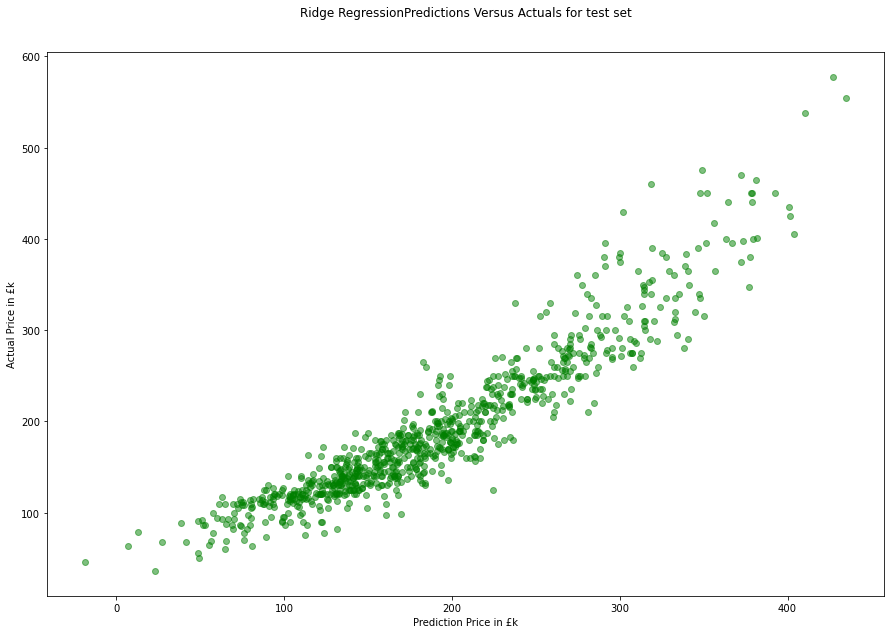

In [56]:
test_data_plot(rr,X_test,y_test,'Ridge Regression')

In [17]:
svr = svr_search.best_estimator_
svr.fit(X_train, y_train)
print('SVR Results:\n')
tuned_model_evaluation(svr_search.best_estimator_,X_test,y_test)

SVR Results:


R2 Model score: : 0.94%
MSE:  403.2
MAE:  12.15
Average Percentage difference:: 6.33%
RMSE: 20.08
95% confidence interval:  [17.11704424 22.65830416]
Max £ difference:  150.575

Median £ difference:  7.74
Median actual price: 171.95  Median pedicted price: 170.381

Number of predictions over 10% wrong:  142 out of  859
Number of predictions 10% wrong or less:  717 out of  859


,actual,pred,diff,percent_diff
0,163.500,165.902,2.402e+00,1.469e+00
1,118.000,116.931,1.069e+00,9.059e-01
2,160.000,158.383,1.617e+00,1.011e+00
3,397.500,403.100,5.600e+00,1.409e+00
4,125.000,129.145,4.145e+00,3.316e+00
5,176.000,171.399,4.601e+00,2.614e+00
6,150.000,140.563,9.437e+00,6.291e+00
7,325.000,317.279,7.721e+00,2.376e+00
8,185.000,190.994,5.994e+00,3.240e+00
9,179.950,177.426,2.524e+00,1.403e+00


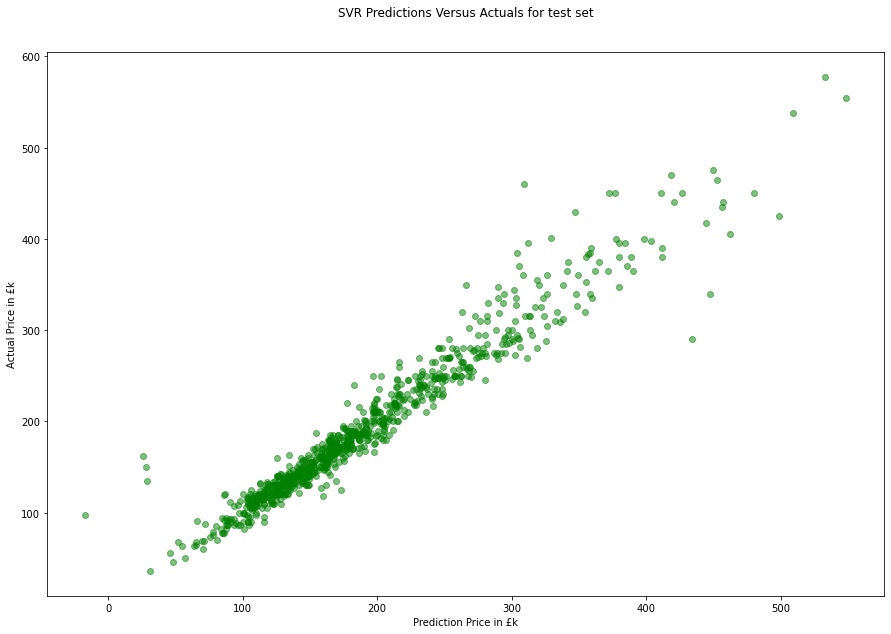

In [57]:
test_data_plot(svr,X_test,y_test,'SVR ')

#### No direct interpretability for SVR 

## Extra Trees

In [19]:
et = et_search.best_estimator_
et.fit(X_train, y_train)
print('Extra Trees Results:\n')
tuned_model_evaluation(et_search.best_estimator_,X_test,y_test)

Extra Trees Results:


R2 Model score: : 0.94%
MSE:  398.6
MAE:  12.46
Average Percentage difference:: 6.50%
RMSE: 19.965
95% confidence interval:  [16.53091203 22.88942148]
Max £ difference:  213.656

Median £ difference:  8.008
Median actual price: 171.95  Median pedicted price: 174.315

Number of predictions over 10% wrong:  170 out of  859
Number of predictions 10% wrong or less:  689 out of  859


,actual,pred,diff,percent_diff
0,163.500,161.492,2.008,1.228
1,118.000,130.266,12.266,10.395
2,160.000,158.799,1.201,0.750
3,397.500,390.859,6.641,1.671
4,125.000,128.463,3.463,2.770
5,176.000,193.791,17.791,10.109
6,150.000,156.401,6.401,4.267
7,325.000,329.459,4.459,1.372
8,185.000,184.081,0.919,0.497
9,179.950,185.903,5.953,3.308


In [20]:
#Find the feature importances used in the model
et_feat_imp = pd.DataFrame(list(zip(et.feature_importances_, cols)), columns = ['importance', 'feature'])
et_feat_imp = et_feat_imp.sort_values('importance', ascending = False, key = abs).reset_index(drop = True)
et_feat_imp['sum_importance'] = et_feat_imp['importance'].cumsum()
et_feat_imp.to_csv('et_feat_imp.csv')
et_feat_imp

,importance,feature,sum_importance
0,0.252,median_income,0.252
1,0.074,year,0.326
2,0.069,rpi,0.395
3,0.068,prop_flat_sls,0.462
4,0.063,prop_semi_sls,0.526
5,0.051,gdp_hh,0.576
6,0.047,prop_terr_sls,0.623
7,0.042,ratio_new_exist_prices,0.665
8,0.030,prop_hh_1_person,0.696
9,0.022,prop_det_sls,0.717


Text(0, 0.5, 'Importance Value')

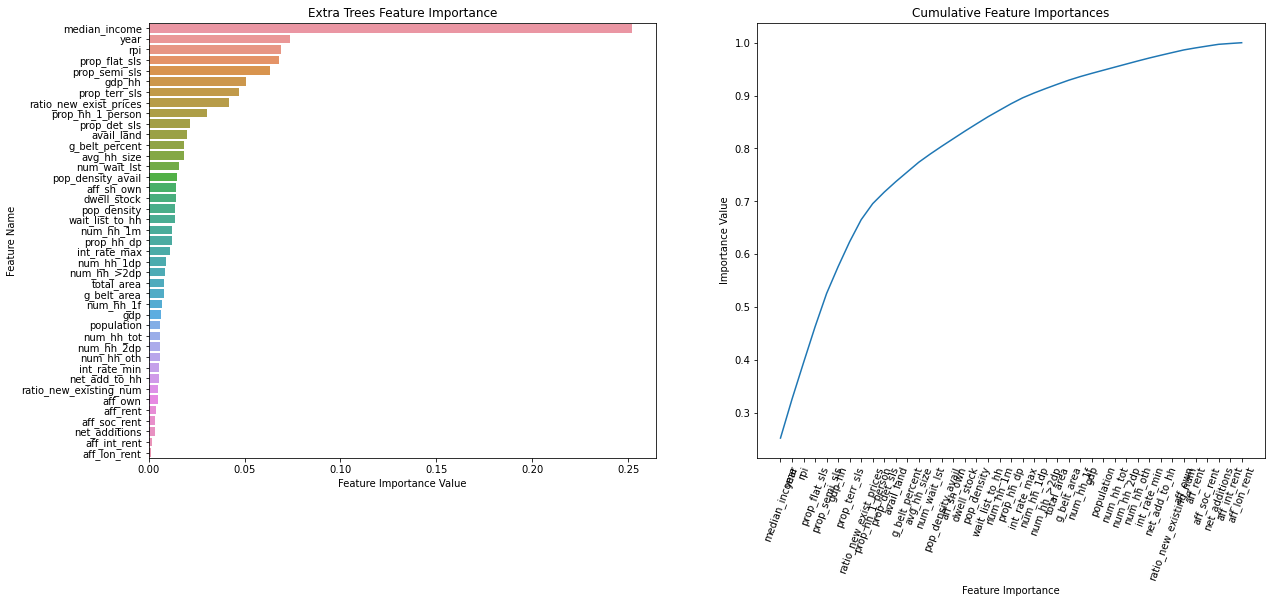

In [21]:
plt.figure(figsize = (20,8))
ax = plt.subplot(1,2,1)

sns.barplot(x=et_feat_imp['importance'], y=et_feat_imp['feature'])
plt.title('Extra Trees Feature Importance')
plt.xlabel('Feature Importance Value')
plt.ylabel('Feature Name')

ax =plt.subplot(1,2,2)
plt.plot(et_feat_imp['sum_importance'])
plt.title('Cumulative Feature Importances')
plt.xlabel('Feature Importance')
ax.set_xticks(range(len(et_feat_imp['feature'])))
ax.set_xticklabels(et_feat_imp['feature'], rotation = 70)
plt.ylabel('Importance Value')
#plt.show()

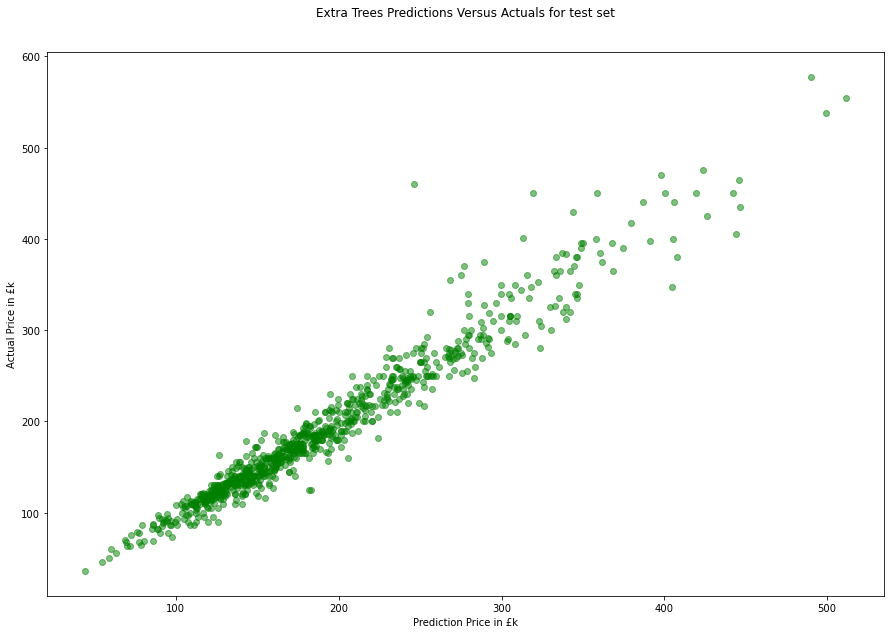

In [58]:
test_data_plot(et,X_test,y_test,'Extra Trees ')

In [23]:
kn = kn_search.best_estimator_
kn.fit(X_train, y_train)
print('KNR Results:\n')
tuned_model_evaluation(kn_search.best_estimator_,X_test,y_test)

KNR Results:


R2 Model score: : 0.92%
MSE:  550.0
MAE:  14.84
Average Percentage difference:: 7.74%
RMSE: 23.452
95% confidence interval:  [20.12119199 26.36552063]
Max £ difference:  221.062

Median £ difference:  8.911
Median actual price: 171.95  Median pedicted price: 175.528

Number of predictions over 10% wrong:  233 out of  859
Number of predictions 10% wrong or less:  626 out of  859


,actual,pred,diff,percent_diff
0,163.500,159.526,3.974,2.431
1,118.000,119.142,1.142,0.968
2,160.000,165.960,5.960,3.725
3,397.500,394.807,2.693,0.677
4,125.000,133.684,8.684,6.948
5,176.000,202.146,26.146,14.856
6,150.000,153.319,3.319,2.213
7,325.000,298.973,26.027,8.008
8,185.000,192.481,7.481,4.044
9,179.950,179.920,0.030,0.017


Failed to find a way to represent the features and their importance

# Modelling on the reduced feature set

In [24]:
# reduced feature set - same as used in NN. 
train_best = pd.read_csv('train_best.csv')
train_best = train_best.drop(columns = 'Unnamed: 0')
test_best = pd.read_csv('test_best.csv')
test_best = test_best.drop(columns = 'Unnamed: 0')

In [25]:
train_best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_area              3425 non-null   int64  
 1   pop_density_avail       3425 non-null   float64
 2   prop_semi_sls           3425 non-null   float64
 3   median_income           3425 non-null   int64  
 4   gdp_hh                  3425 non-null   float64
 5   prop_flat_sls           3425 non-null   float64
 6   prop_hh_1_person        3425 non-null   float64
 7   avail_land              3425 non-null   float64
 8   year                    3425 non-null   int64  
 9   rpi                     3425 non-null   float64
 10  num_wait_lst            3425 non-null   float64
 11  ratio_new_exist_prices  3425 non-null   float64
 12  prop_det_sls            3425 non-null   float64
 13  aff_rent                3425 non-null   float64
 14  aff_sh_own              3425 non-null   

In [26]:
#scale the data
X_train_b = train_best.iloc[ : , 0:31]
y_train_b = train_best.iloc[ : , -1]

X_test_b = test_best.iloc[ : , 0:31]
y_test_b = test_best.iloc[ : , -1]

scaler = MinMaxScaler()
scaler.fit(X_train_b)
X_train_b = scaler.fit_transform(X_train_b)

X_test_b = scaler.transform(X_test_b)

X_train_b.shape, y_train_b.shape, X_test_b.shape, y_test_b.shape

((3425, 31), (3425,), (859, 31), (859,))

In [27]:
# Spot check the models again. Expect the worst performers still are, but should be better generally
# SVR still for comparison to benchmark NN, not an interpretable model (there are papers suggesting ways to deliver)
models = []
models.append(('LR', LinearRegression(fit_intercept = True)))
models.append(('RR', Ridge()))
models.append(('SVR', SVR(kernel = 'poly')))
models.append(('KNN', KNeighborsRegressor()))
models.append(('ET', ExtraTreesRegressor(random_state = 3)))
models.append(('RF', RandomForestRegressor(random_state = 3)))

In [28]:
results = []
names = []
scoring = ('neg_mean_absolute_error')
for name, model in models:
    kfold = KFold(n_splits = 10, random_state = 3, shuffle = True)
    cv_results = cross_val_score(model, X_train_b, y_train_b, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print(name, round(cv_results.mean(),3), round(cv_results.std(),3))

LR -23.129 1.162
RR -24.543 1.137
SVR -22.554 0.84
KNN -18.024 0.708
ET -13.403 0.815
RF -17.398 0.884


 All round performance improved.
 
 No tuning for LR, if RR is the same or better than LR after tuning, use RR, otherwise use LR for test

### Tuning

In [29]:
# Grid search tuning
param_grid ={'alpha':[0.0001,0.001,0.01],
             'solver': ['svd', 'cholesky', 'lsqr', 'saga'],
             'fit_intercept': [True, False]}

rr_best = Ridge()
scoring = 'neg_mean_absolute_error'
rr_search_best = GridSearchCV(rr_best, param_grid, cv=5, scoring = scoring, return_train_score = True)

rr_search_best.fit(X_train_b, y_train_b)
print(rr_search_best.best_estimator_)
print(round(abs(rr_search_best.best_score_),3))

Ridge(alpha=0.0001, solver='svd')
23.116


Both LR & RR very similar. Continue with RR as comparitive to  full dataset above , the parameters are so small as to make the ridge almost a linear regression model 

In [30]:
# SVR tuning
param_grid ={'C':[100,200,300,400],
             'kernel': ['poly'],
             'degree': [2,3,4,5]}

svr_best = SVR()
scoring = 'neg_mean_absolute_error'
svr_search_best = GridSearchCV(svr_best, param_grid, cv=5, scoring = scoring, return_train_score = True)

svr_search_best.fit(X_train_b, y_train_b)
print(svr_search_best.best_estimator_)
print(round(abs(svr_search_best.best_score_),3))

SVR(C=400, degree=4, kernel='poly')
11.494


In [31]:
# Grid search tuning:
param_grid = {'n_estimators': [50,100, 150],
               'min_samples_leaf':[1,2,3],
             'max_depth':[30,50]}



et_best = ExtraTreesRegressor(random_state = 3)
scoring = 'neg_mean_absolute_error'
et_search_best = GridSearchCV(et_best, param_grid, cv=5, scoring = scoring, return_train_score = True)

et_search_best.fit(X_train_b, y_train_b)
print(et_search_best.best_estimator_)
print(round(abs(et_search.best_score_),3))

ExtraTreesRegressor(max_depth=50, n_estimators=150, random_state=3)
13.892


## Apply to Test Set

#### Ridge Regression

In [32]:
rr_best = rr_search_best.best_estimator_
rr_best.fit(X_train_b, y_train_b)
print('Ridge Regression Results on Best Features:\n')
tuned_model_evaluation(rr_search_best.best_estimator_,X_test_b,y_test_b)

Ridge Regression Results on Best Features:


R2 Model score: : 0.86%
MSE:  949.63
MAE:  22.26
Average Percentage difference:: 11.60%
RMSE: 30.816
95% confidence interval:  [28.22924893 33.2020965 ]
Max £ difference:  187.258

Median £ difference:  16.585
Median actual price: 171.95  Median pedicted price: 178.89

Number of predictions over 10% wrong:  412 out of  859
Number of predictions 10% wrong or less:  447 out of  859


,actual,pred,diff,percent_diff
0,163.500,173.475,9.975,6.101
1,118.000,113.768,4.232,3.587
2,160.000,138.941,21.059,13.162
3,397.500,365.340,32.160,8.090
4,125.000,141.223,16.223,12.978
5,176.000,215.361,39.361,22.364
6,150.000,123.931,26.069,17.379
7,325.000,308.757,16.243,4.998
8,185.000,197.009,12.009,6.491
9,179.950,227.591,47.641,26.474


In [33]:
#Find the coefficients used in the model
cols = train_best.columns[0:31]
rr_coefs_best = pd.DataFrame(list(zip(rr_best.coef_, cols)), columns = ['coef', 'feature'])
rr_coefs_best = rr_coefs_best.sort_values('coef', ascending = False, key = abs).reset_index(drop = True)
rr_coefs_best.to_csv('rr_coefs_best.csv')
rr_coefs_best


,coef,feature
0,2045.920,population
1,-1231.937,num_hh_1dp
2,-1017.157,num_hh_oth
3,948.417,num_hh_2dp
4,-751.167,num_hh_>2dp
5,211.884,year
6,139.754,prop_flat_sls
7,-136.226,pop_density
8,-117.854,net_additions
9,97.839,pop_density_avail


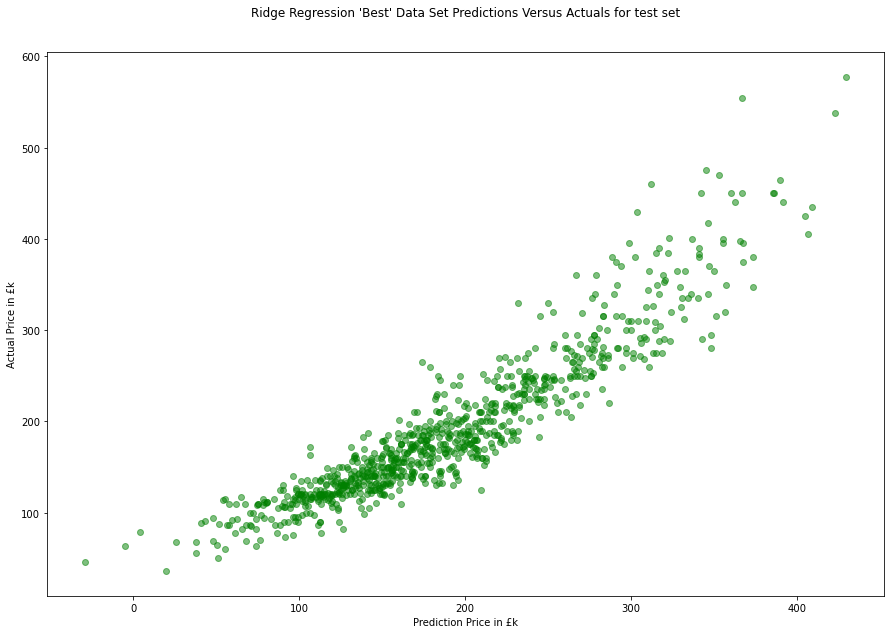

In [59]:
test_data_plot(rr_best,X_test_b,y_test_b,'Ridge Regression \'Best\' Data Set ')

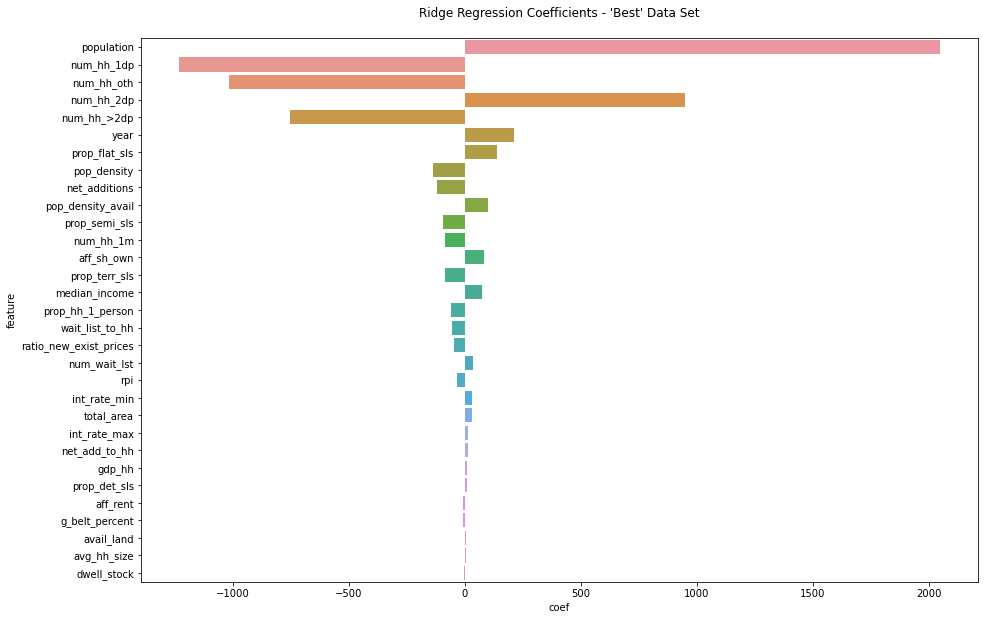

In [35]:
plt.figure(figsize=(15,10))
sns.barplot(data = rr_coefs_best, x = 'coef', y = 'feature')
plt.title('Ridge Regression Coefficients - \'Best\' Data Set\n')
plt.show()

#### SVR

In [36]:
svr_best = svr_search_best.best_estimator_
svr_best.fit(X_train_b, y_train_b)
print('SVR Results on Best Features:\n')
tuned_model_evaluation(svr_search_best.best_estimator_,X_test_b,y_test_b)

SVR Results on Best Features:


R2 Model score: : 0.95%
MSE:  340.25
MAE:  11.81
Average Percentage difference:: 6.16%
RMSE: 18.446
95% confidence interval:  [16.06728539 20.55099011]
Max £ difference:  149.902

Median £ difference:  7.808
Median actual price: 171.95  Median pedicted price: 170.786

Number of predictions over 10% wrong:  149 out of  859
Number of predictions 10% wrong or less:  710 out of  859


,actual,pred,diff,percent_diff
0,163.500,169.367,5.867,3.588
1,118.000,121.924,3.924,3.325
2,160.000,156.758,3.242,2.026
3,397.500,408.698,11.198,2.817
4,125.000,125.717,0.717,0.574
5,176.000,173.654,2.346,1.333
6,150.000,147.232,2.768,1.845
7,325.000,317.462,7.538,2.319
8,185.000,192.586,7.586,4.101
9,179.950,191.466,11.516,6.399


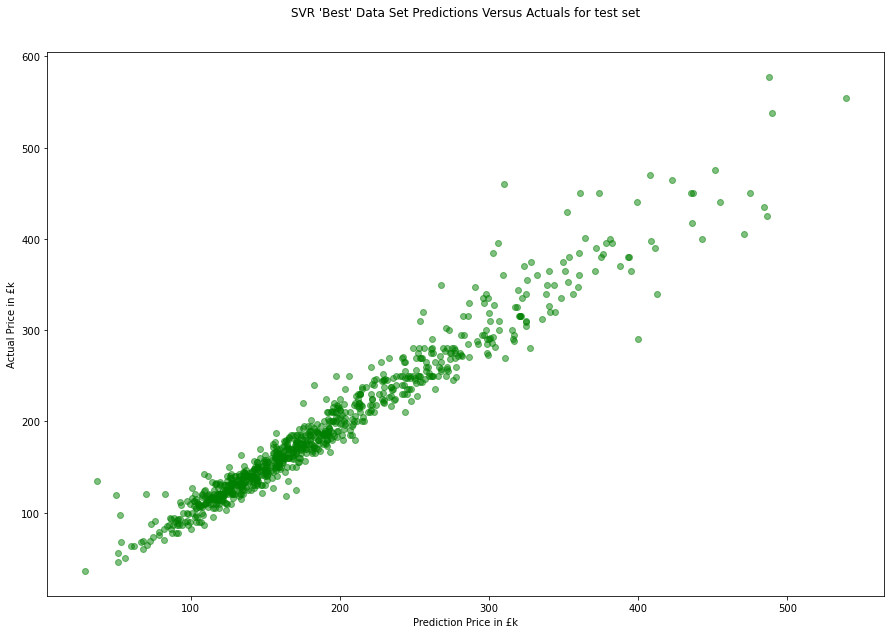

In [60]:
test_data_plot(svr_best,X_test_b,y_test_b,'SVR \'Best\' Data Set ')

#### Extra Trees

In [38]:
et_best = et_search_best.best_estimator_
et_best.fit(X_train_b, y_train_b)
print('Extra Trees Results on Best Features:\n')
tuned_model_evaluation(et_search_best.best_estimator_,X_test_b,y_test_b)

Extra Trees Results on Best Features:


R2 Model score: : 0.94%
MSE:  404.56
MAE:  12.53
Average Percentage difference:: 6.53%
RMSE: 20.114
95% confidence interval:  [16.48451223 23.18145227]
Max £ difference:  219.338

Median £ difference:  8.018
Median actual price: 171.95  Median pedicted price: 173.559

Number of predictions over 10% wrong:  161 out of  859
Number of predictions 10% wrong or less:  698 out of  859


,actual,pred,diff,percent_diff
0,163.500,158.123,5.377,3.288
1,118.000,133.786,15.786,13.378
2,160.000,155.857,4.143,2.590
3,397.500,394.623,2.877,0.724
4,125.000,128.980,3.980,3.184
5,176.000,193.067,17.067,9.697
6,150.000,153.707,3.707,2.471
7,325.000,327.329,2.329,0.717
8,185.000,185.021,0.021,0.012
9,179.950,184.722,4.772,2.652


In [39]:
#Find the feature importances used in the model
et_feat_imp_best = pd.DataFrame(list(zip(et_best.feature_importances_, cols)), columns = ['importance', 'feature'])
et_feat_imp_best = et_feat_imp_best.sort_values('importance', ascending = False).reset_index(drop = True)
et_feat_imp_best['sum_importance'] = et_feat_imp_best['importance'].cumsum(axis= 0)
et_feat_imp_best.to_csv('et_feat_imp_best.csv')

et_feat_imp_best.head(32)

,importance,feature,sum_importance
0,0.251,median_income,0.251
1,0.082,year,0.332
2,0.072,prop_semi_sls,0.405
3,0.067,rpi,0.471
4,0.065,prop_flat_sls,0.536
5,0.057,gdp_hh,0.593
6,0.048,prop_terr_sls,0.641
7,0.047,ratio_new_exist_prices,0.688
8,0.031,prop_hh_1_person,0.719
9,0.023,avail_land,0.742


Text(0, 0.5, 'Importance Value')

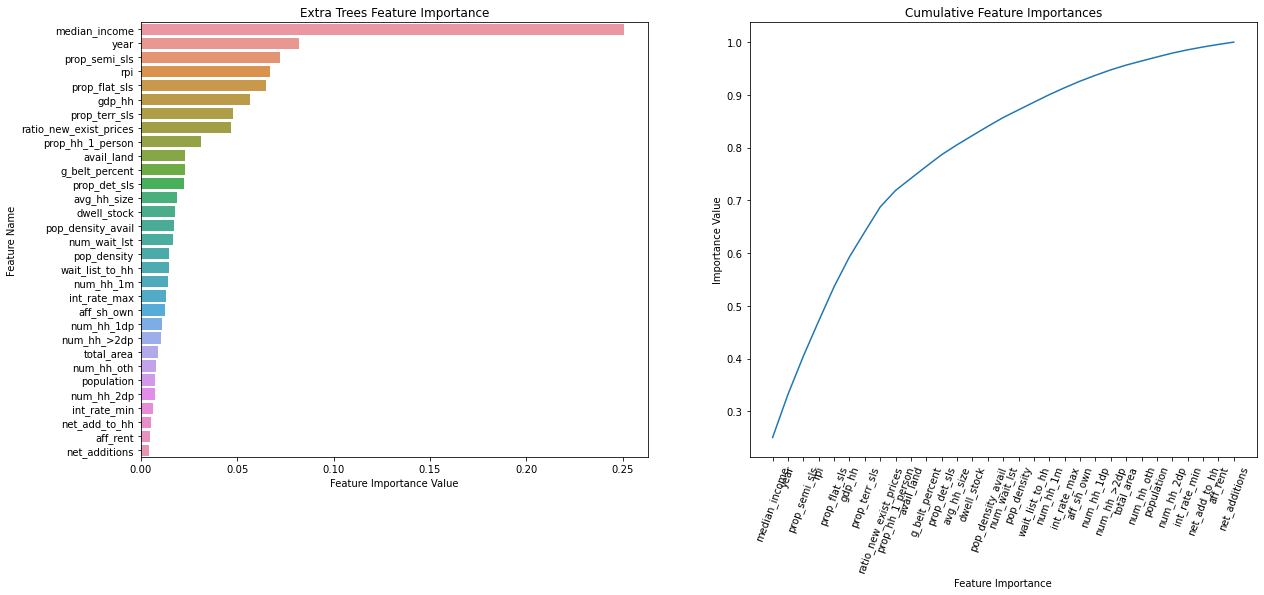

In [40]:
plt.figure(figsize = (20,8))
ax = plt.subplot(1,2,1)

sns.barplot(x=et_feat_imp_best['importance'], y=et_feat_imp_best['feature'])
plt.title('Extra Trees Feature Importance')
plt.xlabel('Feature Importance Value')
plt.ylabel('Feature Name')

ax =plt.subplot(1,2,2)
plt.plot(et_feat_imp_best['sum_importance'])
plt.title('Cumulative Feature Importances')
plt.xlabel('Feature Importance')
ax.set_xticks(range(len(et_feat_imp_best['feature'])))
ax.set_xticklabels(et_feat_imp_best['feature'], rotation = 70)
plt.ylabel('Importance Value')
#plt.show()


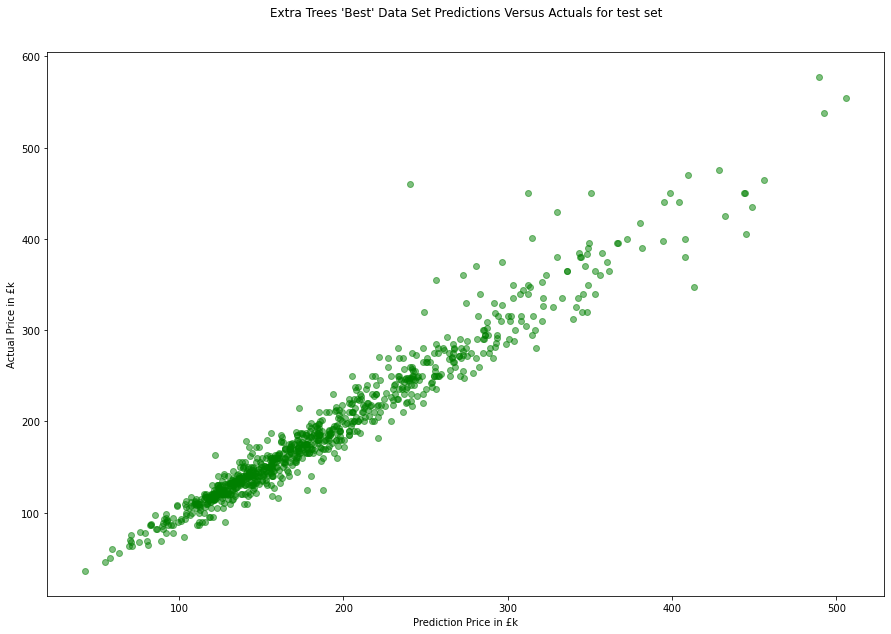

In [61]:
test_data_plot(et_best,X_test_b,y_test_b,'Extra Trees \'Best\' Data Set ')

## Dummy Sets

In [72]:
dummy_double = pd.read_csv('svr_dummy.csv')
dummy_double = dummy_double.rename(columns = {'Unnamed: 0': 'ref'})

dummy_double = dummy_double.set_index('ref')
dummy_double.head(7)

,total_area,pop_density_avail,prop_semi_sls,median_income,gdp_hh,prop_flat_sls,prop_hh_1_person,avail_land,year,rpi,num_wait_lst,ratio_new_exist_prices,prop_det_sls,aff_rent,aff_sh_own,population,avg_hh_size,num_hh_2dp,num_hh_oth,int_rate_max,dwell_stock,prop_terr_sls,net_add_to_hh,g_belt_percent,num_hh_1dp,num_hh_1m,wait_list_to_hh,pop_density,int_rate_min,num_hh_>2dp,net_additions,all_sls_price
ref,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
173,8010,35.403,0.392,23143,0.045,0.052,0.284,0.387,2011,235.2,983,1.050,0.340,0,0,109749,2.347,4897.819,21043.493,0.50,4646,0.216,0.004,0.613,5830.973,5813.278,0.021,13.701,0.50,1705.147,354,132.000
304,33130,5.263,0.300,19295,0.044,0.095,0.242,0.542,2003,181.3,1395,1.429,0.398,0,0,94467,2.488,4720.807,17682.839,3.75,0,0.208,0.013,0.458,4587.821,3875.169,0.037,2.851,3.50,1790.096,958,137.973
367,49710,10.462,0.303,32015,0.107,0.145,0.279,0.537,2017,272.5,4735,1.236,0.244,70,57,279027,2.431,13862.643,48530.009,0.50,11,0.307,0.014,0.463,15877.915,15563.145,0.041,5.613,0.50,4447.554,3260,256.500
491,34220,8.144,0.226,27295,0.070,0.281,0.281,0.625,2016,263.1,5439,0.977,0.255,23,0,174197,2.419,8635.051,31343.177,0.25,37,0.237,0.011,0.375,8937.758,9308.678,0.076,5.091,0.25,2853.606,1584,300.000
599,75220,2.502,0.206,30587,0.067,0.139,0.304,0.934,2021,305.0,1283,1.086,0.478,48,12,175800,2.192,7121.015,37853.987,0.25,5142,0.177,0.005,0.066,8574.853,10146.705,0.016,2.337,0.25,2256.800,844,380.000
602,5740,34.071,0.198,31997,0.077,0.411,0.325,0.977,2013,250.1,4415,0.843,0.069,19,0,191138,2.372,10133.854,30387.364,0.50,0,0.321,0.006,0.023,10444.948,11933.987,0.055,33.299,0.50,3394.743,970,460.000
613,5640,78.993,0.182,31127,0.052,0.362,0.247,0.660,2014,256.0,7804,0.830,0.044,2,0,293853,2.851,14907.244,36763.932,0.50,4558,0.412,0.003,0.340,16919.650,11911.603,0.076,52.102,0.50,8975.385,516,290.000


In [98]:
#Split target and scale
X_dummy_d = dummy_double.iloc[ : , 0:31]
y_dummy_d = dummy_double.iloc[ : , -1]

X_dummy_d = scaler.transform(X_dummy_d)
X_dummy_d.shape

(7, 31)

In [99]:
dummy_data_half = pd.read_csv('svr_dummy_half.csv')
dummy_data_half= dummy_data_half.rename(columns = {'Unnamed: 0': 'ref'})
dummy_data_half = dummy_data_half.set_index('ref')
dummy_data_half.info(7)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 173 to 613
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_area              7 non-null      int64  
 1   pop_density_avail       7 non-null      float64
 2   prop_semi_sls           7 non-null      float64
 3   median_income           7 non-null      int64  
 4   gdp_hh                  7 non-null      float64
 5   prop_flat_sls           7 non-null      float64
 6   prop_hh_1_person        7 non-null      float64
 7   avail_land              7 non-null      float64
 8   year                    7 non-null      int64  
 9   rpi                     7 non-null      float64
 10  num_wait_lst            7 non-null      int64  
 11  ratio_new_exist_prices  7 non-null      float64
 12  prop_det_sls            7 non-null      float64
 13  aff_rent                7 non-null      int64  
 14  aff_sh_own              7 non-null      in

In [100]:
#Split target and scale
X_dummy_h = dummy_data_half.iloc[ : , 0:31]
y_dummy_h = dummy_data_half.iloc[ : , -1]

X_dummy_h = scaler.transform(X_dummy_h)

In [101]:
X_dummy_d.shape

(7, 31)

In [102]:
def create_preds(test, doubled, halved):
    df_d = pd.DataFrame(doubled, columns = ['actual','pred']).rename(columns = {'pred': 'd_pred'})
    df_h = pd.DataFrame(halved, columns = ['actual', 'pred']).rename(columns = {'pred': 'h_pred'})
    df_p = pd.DataFrame(test, columns = ['actual', 'pred']).rename(columns = {'pred': 'pred'})
    df_p = df_p.iloc[[173,304,367,491,599,602,613]].reset_index(drop = True)
    df_d = df_d.merge(df_h, left_index = True, right_index = True)
    df_d = df_d.merge(df_p, left_index = True, right_index = True)
    df_d = df_d.drop(columns = ['actual_y', 'actual'])
    df_d['obs_ref'] = [173,304,367,491,599,602,613]
    df_d.columns = ['actual', 'd_pred', 'h_pred', 'pred', 'obs_ref']
    return df_d

In [103]:
def plot_dummy(df, model_name):
    plt.figure(figsize=(15,10))
    n=1
    t=4
    d=7
    w=0.8
    x_1 = [t*element +w*n for element in range(d)]
    bar1 = plt.bar(x_1,df.actual, color = 'darkseagreen')
    n=2
    x_2 = [t*element +w*n for element in range(d)]
    bar2 = plt.bar(x_2,df.pred, color = 'cadetblue')
    n=3
    x_3 = [t*element +w*n for element in range(d)]
    bar3 = plt.bar(x_3,df.d_pred,color = 'lavender')
    n=4
    x_4 = [t*element +w*n for element in range(d)]
    bar4 = plt.bar(x_4,df.h_pred,color = 'lightblue')

    plt.xlabel('Pred/Actual Observations')
    plt.ylabel('Sales price £k')
    plt.legend((bar1,bar2,bar3,bar4),('Actual', 'Original Prediction', '2x Net Additions', 'Halved Net Additions'))
    plt.title(model_name+' '+' Actual Price and Predicted Prices with Net Additions Adjusted\n')
    ax = plt.subplot()
    ax.set_xticks((np.array(x_1)+np.array(x_2))/2)
    ax.set_xticklabels(df.obs_ref)
    plt.grid(axis = 'y')
    plt.show()

In [104]:
def plot_diffs(df, model_name):
   
    df['h_vs_pred'] = (df['h_pred']-df['pred'])/df['pred']
    df['d_vs_pred'] = (df['d_pred']-df['pred'])/df['pred']
    new_df = pd.DataFrame(df[['obs_ref','h_vs_pred','d_vs_pred']])
    new_df = new_df.melt(id_vars = 'obs_ref')
    
    plt.figure(figsize=(15,10))
    sns.barplot(x = 'obs_ref', y = 'value', hue = 'variable', data = new_df, palette ='BuGn')
    plt.xticks(rotation=90)
    plt.ylabel('% Difference to Prediction')
    plt.title(model_name+' '+'Doubled & Halved Net additions Impact on Predictions')
    plt.show()
    

### SVR

In [105]:
svr_doubled = tuned_model_evaluation(svr_search_best.best_estimator_,X_dummy_d,y_dummy_d)
svr_halved = tuned_model_evaluation(svr_search_best.best_estimator_,X_dummy_h,y_dummy_h)
svr_pred = tuned_model_evaluation(svr_search_best.best_estimator_,X_test_b,y_test_b)


R2 Model score: : 0.61%
MSE:  4714.68
MAE:  44.57
Average Percentage difference:: 15.95%
RMSE: 68.664
95% confidence interval:  [         nan 109.47578098]
Max £ difference:  136.988

Median £ difference:  16.459
Median actual price: 290.0  Median pedicted price: 316.459

Number of predictions over 10% wrong:  3 out of  7
Number of predictions 10% wrong or less:  4 out of  7

R2 Model score: : 0.57%
MSE:  5215.31
MAE:  43.71
Average Percentage difference:: 15.64%
RMSE: 72.217
95% confidence interval:  [         nan 118.21414308]
Max £ difference:  156.248

Median £ difference:  10.724
Median actual price: 290.0  Median pedicted price: 301.696

Number of predictions over 10% wrong:  2 out of  7
Number of predictions 10% wrong or less:  5 out of  7

R2 Model score: : 0.95%
MSE:  340.25
MAE:  11.81
Average Percentage difference:: 6.16%
RMSE: 18.446
95% confidence interval:  [16.06728539 20.55099011]
Max £ difference:  149.902

Median £ difference:  7.808
Median actual price: 171.95  Medi

In [107]:
svr_d = create_preds(svr_pred,svr_doubled, svr_halved)
# plot_dummy(svr_d, 'SVR')
# svr_d.to_csv('svr_d_ouput.csv')
svr_d

,actual,d_pred,h_pred,pred,obs_ref
0,132.000,128.655,126.489,127.204,173
1,137.973,144.787,141.879,142.806,304
2,256.500,282.389,235.904,251.017,367
3,300.000,316.459,301.696,306.564,491
4,380.000,387.675,369.276,375.415,599
5,460.000,323.012,303.752,310.098,602
6,290.000,404.802,397.265,399.766,613


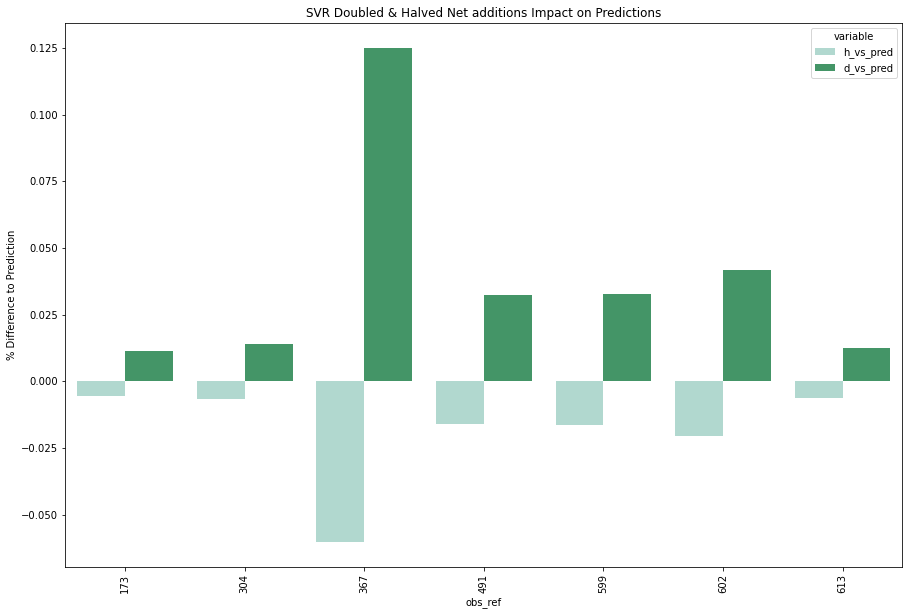

In [108]:
plot_diffs(svr_d, 'SVR')

In [109]:
svr_d.to_csv('svr_dummy_output.csv')